## Prepare Datasets for Characters lemmatization
There are numerous Characters in Game of Thrones. The text often refers to them using only their firstname. We want to get a lemma of each name so this can be used in the graph later. The goal is to find the most probable lemma according to the mention in the text. 

To get the lemma, we need a list of characters. To date the best list is in [the wiki of ice and fire](https://awoiaf.westeros.org/index.php/List_of_characters)

### Scrape the characters list page
the scraping returns the text of the page and we load it into beautiful soup to have a DOM mount of it. 
We extract all links to character's page from the wiki and get all pages.
Save all HTML for further analysis

### get all the link that point to a character in the wiki
the get the links we browse the HTML looking for 

```html
    <a href="">name</a>
```
tag and get only those who follow a certain template. 
Then we have a list of pages to get as tuples (href, name)


In [ ]:
import requests
from bs4 import BeautifulSoup
import time 

# requests to the awoif wiki list of characters
r = requests.get('https://awoiaf.westeros.org/index.php/List_of_characters')
soup = BeautifulSoup(r.text)

# extract all anchors (links). Take only the first anchor after an li
links = soup.select('div#mw-content-text ul > li > a:nth-of-type(1)')
pages = []
for link in links:
    # create a tuple with the link and the character name
    pages.append((link['href'],link['href'].split('/')[-1]))

# create a set to remove duplicates
pages = set(pages)

# add missing pages the wiki did not properly linked
pages.add(('/index.php/Rhaenyra_Targaryen','Rhaenyra_Targaryen'))
pages.add(('/index.php/Jason_Lannister_(son_of_Gerold)','Jason_Lannister_(son_of_Gerold)'))
pages.add(('/index.php/Maekar_I_Targaryen','Maekar_I_Targaryen'))

### Start downloading all html files
To handle errors and connection timeout, we download only those who hase not been downloaded yet. 

The faster way to handle this is to create use the difference between two sets
* __downloaded__ set contains the files already in the directory data/html/
* __pages__ set contains the whole list 
* __pending__ set contains __pages__-__downloaded__
Pending are then downloaded one by one with a security pause of 1 sec between each request

In [102]:
downloaded = set()
for root, dirs, files in os.walk('data/html'):
    for name in files:
        if name.endswith('.html'):
            url = '/index.php/'+name[:-5]
            downloaded.add((url,name[:-5]))
pending = pages - downloaded
print('still',len(pending),'pages to download. Estimated:',len(pending)*2/60,'min' )

# for each link, download the page and store on disk
for href,name in pending:
    r = requests.get('https://awoiaf.westeros.org' + href)
    with open('data/html/'+ name+'.html','w+', encoding='utf-8') as fp:
        fp.write(r.text)
        time.sleep(1)

still 1 pages to download. Estimated: 0.016666666666666666 min


### analysis of html page: getCharacterDict
We are after several informations:
* Short name (title of the infobox)
* common name (title of the __page__)
* full name (field of the infobox)
* title (field of the infobox)
* aliases (field of the infobox) 
* book list (field of the infobox)
* infobox items count (field of the infobox)
* category (how character appears in the book, books field) 

if no infobox is found, the character is discarded

The code use a variety of technics to extract, clean and array each field
Biggest technical difficulty is the cleaning code:
* aliases, title and books in the format `'BranStark (appears)[N 1]'` that needs to be transformed into `['Bran', 'Sark']`. This is achieved with regular expressions matching certain patterns in the text. An example of the regex used in this example is available on [regex101.com](https://regex101.com/r/5gYvlQ/1).
* books volume title is converted into a number with the use of a dictionary


In [3]:
def cleanedAndArrayed(rawText):
    """
    clean and array the scrapped raw text

    First cleaning: use a pattern regular expression to suppress parenthesis and references field. 
    Second Splitting: split cleaned text into items when the patterns lowercaseUPPERCASE is found. 

    Parameters
    —————
    rawText : the raw text from infobox  

    Returns
    ———
    array of string items
        the cleaned and arrayed rawText
    """
    
    # transform: Ser (a title from ancient kingdoms)[N 1]Prince -> SerPrince
    regex = r"((\[([a-zA-Z0-9]\s?)+\])|(\s?\(([a-zA-Z0-9]\s?)+\)))"
    subst = ''
    cleaned = re.sub(regex, subst, rawText)
    regex = r"([a-z])([A-Z])"
    subst = "\\1, \\2"
    cleaned = re.sub(regex, subst, cleaned)
    # transform: SerPrince -> ['Ser', 'Prince']
    arrayed = [i.strip() for i in cleaned.split(',')]
    return arrayed

In [34]:
books_vol = {
    'A Game of Thrones':1,
    'A Clash of Kings':2,
    'A Storm of Swords':3,
    'A Feast for Crows':4,
    'A Dance with Dragons':5
}

def getCharacterDict(soup):
    """
    extract informations from page html extract

    Check for every field required for testing names in the nlp analysis
    Field is identified in the infobox or entire page, cleaned and arrayed
    The character is discarded if not mentioned in the books we have

    Parameters
    —————
    soup : BeautifulSoup html soup containng the whole awoif page 

    Returns
    ———
    dict of characters properties
    """
    
    fullname = None
    aliases = None
    titles = None
    category=None
    books = []
    
    # the COMMON NAME – PAGE
    try:
        common_name = soup.find('h1', class_='firstHeading').text.strip()
    except:
        common_name = None        

    infobox = soup.find("table", class_="infobox")
    if infobox is None:
        return None
    
    # the SHORT NAME – INFOBOX
    if infobox.caption is not None:
        short_name = infobox.caption.text.strip()
    else:
        short_name = infobox.tbody.tr.th.text.strip()
        
    rows = infobox.tbody.find_all("tr")

    # infobox fields for as a ranking function
    td_count = 0
    for row in rows:
        for child in row.children:
            if child.name == 'th':
                tds = child.find_all('td')
                td_count += len(tds)
                # the fullname is a longer version of the common name (title of the page)
                if row.th.text.lower().strip() =='full name':
                    fullname = row.td.text.strip()

                # title is sometimes used with the firstname. We keep it to try for title + common_name 
                if row.th.text.lower().strip() == 'title':
                    raw = row.td.text.strip()
                    titles = cleanedAndArrayed(raw)
                
                # aliases are other references to a common name
                if row.th.text.lower().strip() =='alias':
                    raw = row.td.text.strip()
                    aliases = cleanedAndArrayed(raw)
                
                # we transform books titles into indexes corresponding to our chapter indexes
                if row.th.text.lower().strip() == 'book(s)' or row.th.text.lower().strip() == 'books':
                    raw = row.td.text.strip()
                    
                    categories={}
                    if '(POV)' in raw:
                        category = 'POV'
                    else:
                        categories['appears'] = raw.count('(appears)')
                        categories['mentioned'] = raw.count('(mentioned)')
                        categories['appendix'] = raw.count('(appendix)')
                        category = sorted(categories.items(), key=lambda kv:kv[1], reverse=True)[0][0]
                    # if more appendix -> appendix
                    # if more mentioned -> mention
                    
                    books = cleanedAndArrayed(raw)
                    books = [books_vol[b] for b in books if b in books_vol.keys()]

    # if no books were found, the character is discarded           
    if len(books) == 0:
        return None
    else:
        return {'short_name':short_name, 'common_name':common_name, 'fullname':fullname, 'titles':titles,'aliases':aliases, 'books':books, 'awoif_infobox_length':td_count, 'category':category}

### function definition : get characters internal links
for graph creation purposes we save all links from one character into an array

In [35]:
def getCharacterLinks(soup,names):
    cLinks = []
    links = soup.find_all('a')
    for link in links:
        if 'href' in link.attrs.keys():
            name = link['href'].split('/')[-1]
            if name in names:
                cLinks.append(name)
    return cLinks

### helper function display: display formatetd informations

In [36]:
def display(character):
    print(character['common_name'])
    print('\t',character['titles'])
    print('\t',character['aliases'])
    print('\t',character['books'])

## Main Loop

We read the whole directory data/html containing the files. 
For each html file we mount the DOM and pass it to the two functions to get characters informations as well as links


In [37]:
from bs4 import BeautifulSoup
import os
import re

characters = []
names = []

for root, dirs, files in os.walk('data/html'):
    for name in files:
        if name.endswith('.html'):
            names.append(name[:-5])

    for name in files:
        if name.endswith('.html'):
            with open(os.path.join(root, name),'r') as fp:
                html = fp.read()
                soup = BeautifulSoup(html,'lxml')
                character = getCharacterDict(soup)
                if character is not None:
                    #display(character)
                    character['url'] = name[:-5]
                    character['awoif_links'] = getCharacterLinks(soup,names)
                    character['awoif_page_size'] = os.path.getsize(os.path.join(root, name))
                    characters.append(character)

## Some fields are created to allow future ranking function
* **awoif_links**: internal links with other characters
* **awoif_infobox_length**: count the field of infobox
* **awoif_page_size**: size of the page in bytes 
* **awoif_infobox_length_norm**: count the field of infobox
* **awoif_page_size_norm**: size of the page in bytes 

the normalization is created in the code below

In [38]:
# create a graph to get in and out degree of every character
import networkx as nx

awoif_graph = nx.DiGraph()
awoif_graph.add_nodes_from([c['url'] for c in characters])

for character in characters:
    for link in character['awoif_links']:
        awoif_graph.add_edge(character['url'],link)

for i in range(len(characters)):
    characters[i]['awoif_in_degree'] = awoif_graph.in_degree(characters[i]['url'])
    characters[i]['awoif_out_degree'] = awoif_graph.out_degree(characters[i]['url'])
nx.write_gexf(G=awoif_graph,path='awoif-graph.gexf')

In [39]:
import pandas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial import distance

df  = pandas.DataFrame.from_dict(characters)
scaler = MinMaxScaler()
score = scaler.fit_transform(df[['awoif_infobox_length','awoif_page_size','awoif_in_degree','awoif_out_degree']])
df['score'] = [distance.euclidean(s,[0,0,0,0]) for s in score]

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([0.90849114, 0.05873191, 0.03277695, 0.        ])

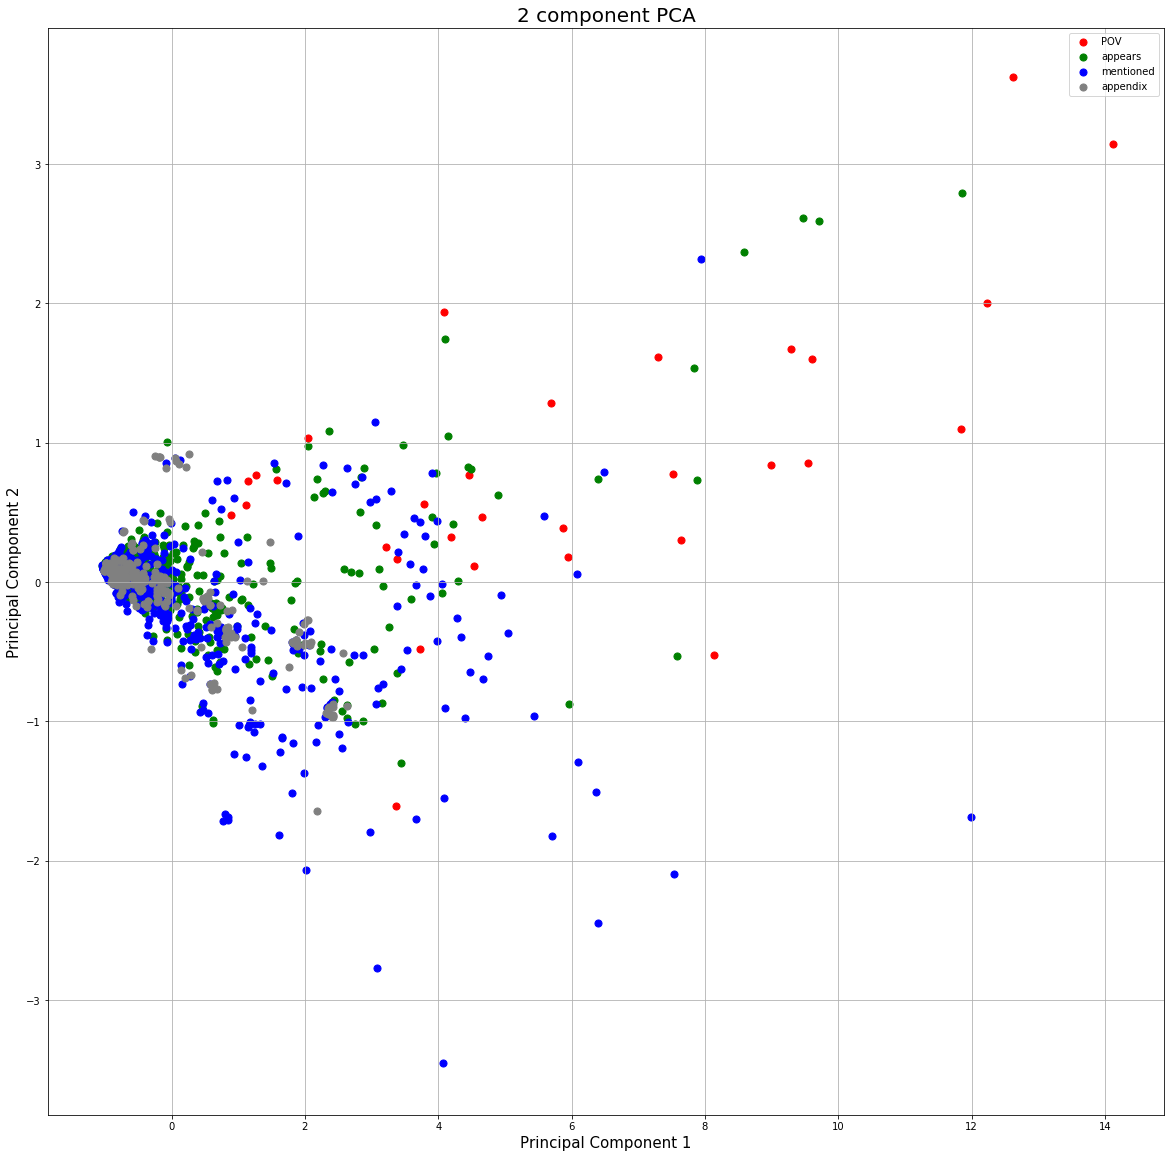

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

score2 = StandardScaler().fit_transform(df[['awoif_infobox_length','awoif_page_size','awoif_in_degree','awoif_out_degree']])

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(score2)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4'])
finalDf = pandas.concat([principalDf, df[['category']]], axis = 1)

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

categories = ['POV', 'appears', 'mentioned','appendix']
colors = ['red', 'green', 'blue','gray']

for category, color in zip(categories,colors):
    indicesToKeep = finalDf['category'] == category
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(categories)
ax.grid()

pca.explained_variance_ratio_

### Save the dictionaries as a pickle for future use

In [41]:
import pickle
with open('characters.pickle','wb+') as fp:
    pickle.dump(characters, fp)

In [29]:
print(characters[1])
print(characters[10])
print(characters[200])


{'short_name': 'Lamprey', 'common_name': 'Lamprey', 'fullname': None, 'titles': None, 'aliases': ['Lamprey'], 'books': [3], 'awoif_infobox_length': 0, 'category': 'appears', 'url': 'Lamprey', 'awoif_links': ['Davos_Seaworth'], 'awoif_page_size': 21753}
{'short_name': 'Esgred', 'common_name': 'Esgred', 'fullname': None, 'titles': None, 'aliases': None, 'books': [2], 'awoif_infobox_length': 0, 'category': 'mentioned', 'url': 'Esgred', 'awoif_links': ['Esgred', 'Sigrin', 'Theon_Greyjoy', 'Asha_Greyjoy'], 'awoif_page_size': 20590}
{'short_name': 'Old Grey Gull', 'common_name': 'Old Grey Gull', 'fullname': None, 'titles': None, 'aliases': None, 'books': [4, 5], 'awoif_infobox_length': 0, 'category': 'mentioned', 'url': 'Old_Grey_Gull', 'awoif_links': ['Aeron_Greyjoy', 'Euron_Greyjoy'], 'awoif_page_size': 22303}


In [42]:
df.to_csv('test.csv')
